Date Created: 09/25/20
## Goal of Notebook: Analyze Differences in Gene Identifiers: Pham & Function

This notion of pham as a subset of function is an important relationship that we could utilize in future genome generation. For example if pham is a subset then you could imagine that we generate a genome but by functional components then to get actual protien sequences we could generate functionally compatible phams. It makes sense that certain genes need to interface with each other. For structural reasons minor tail protiens and the head to tail connector. For host compatibility like if we need specific holin and lysin to integrate with the specific hosts cell wall.


### High Level Questions:

#### Annotation Error Propagation (this is relatively unrelated to the task at hand)
To what extent is error being propigated through the annotation network? If a genome is annotated inncorrectly will the next genome that is similar grab that error? Anotation of one genome is dependent on current annotated genomes. If a gene is annotated how likely is it to take on the same info as previously annotated genes. Does unique spelling errors show independent thought, likewise, does non-unique misspelled annotations show dependence.

#### Evolution or Functionality?
As shown in the analysis below phams are very specific to cluster. That being said does that mean a gene from one cluster will not be functionally compatible in a genome from another cluster? Or is this because of evolutionary lineage that presents itself in statistical correlation?


In [2]:
# import libraries
import requests 
import pandas as pd
from random import sample 
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys
import scipy

### Load in the data

In [42]:
df_genes = pd.read_csv("data/cleaned_gene_list.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,capsid maturation protease


In [43]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124.0,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781.0,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565.0,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396.0,False,True,63.3


### Gene Content Similairity 
- The number of shared phams between two genomes (based on PhagesDB def)

This metric was made becuase current clustering is whole genome nucleotide similairity, however, not every nucleotide has the same impact on the phage's function.

For example: Burton (A1) 27% GCS with Phlei (A13)

In [37]:
a = "Lilith"
b = "Phlei"

In [38]:
df_a = df_genes[df_genes["phage"]==a][["gene ID","pham"]]
df_a.head()

,gene ID,pham
175592,Lilith_CDS_1,38099
175593,Lilith_CDS_10,34196
175594,Lilith_CDS_11,39511
175595,Lilith_CDS_12,21454
175596,Lilith_CDS_13,8023


In [39]:
df_b = df_genes[df_genes["phage"]==b][["gene ID","pham"]]
df_b.head()

,gene ID,pham
242597,Phlei_CDS_1,36593
242598,Phlei_CDS_10,21454
242599,Phlei_CDS_11,8023
242600,Phlei_CDS_12,15229
242601,Phlei_CDS_13,39449


In [40]:
print("Gene Content Similarity (% shared phams) {} and {}:".format(a,b))
phams_a = list(sorted(df_a["pham"]))
phams_b = list(sorted(df_b["pham"]))
shared_phams = []
for i in phams_a:
    if i in phams_b:
        shared_phams.append(i)

print(100*2*len(shared_phams)/(len(phams_b)+len(phams_a)))

Gene Content Similarity (% shared phams) Lilith and Phlei:
41.666666666666664


### Construct a Bipartite Graph: Pham <-> Function
- Edge: if a gene has pham i and function j then edge i->j represents this observance
- Node: either a function or a pham

This representation can help us understand whether pham is a subset of function. Alternatively a pham could contain multiple functions. Based on this we can better understand the relationship between pham and function.

In [44]:
G = nx.Graph()
for index, row in df_genes.iterrows():
    phage = row["phage"]
    function = row['uncleaned function'] #this notebook was originally created with unclean function data
    pham = row['pham']
    #if not df_phages[df_phages["phage"] == phage].empty:
    print(phage)
    subcluster = df_phages[df_phages["phage"] == phage]["subcluster"].values[0]
    cluster = df_phages[df_phages["phage"] == phage]["cluster"].values[0]
    # ADD PHAM NODE iF it doesn't exist
    if not G.has_node(pham):
        G.add_node(pham, group='pham', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
    else:
        G.nodes[pham]["freq"] += 1
        G.nodes[pham]["clusters"].append(cluster)
        G.nodes[pham]["subclusters"].append(subcluster)
        G.nodes[pham]["phages"].append(phage)

    # ADD FUNCTION NODE if it doesn't exist
    if not G.has_node(function):
        G.add_node(function, group='function', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
    else:
        G.nodes[function]["freq"] += 1
        G.nodes[function]["clusters"].append(cluster)
        G.nodes[function]["subclusters"].append(subcluster)
        G.nodes[function]["phages"].append(phage)

    # ADD EDGE if it doesn't exist or increase weight     
    if G.has_edge(pham, function):
        G.edges[pham, function]["weight"] += 1  
    else:
        G.add_edge(pham, function, weight = 1)


20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
20ES
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244
244


Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abinghost
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogate
Abrogat

Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
Acquire49
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
ActinUp
Adahisdi
Adahisdi
Adahisdi
Adahisdi
Adahisdi
Adahisd

Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adnama
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adolin
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis
Adonis

AgentM
AgentM
AgentM
AgentM
AgentM
AgentM
AgentM
AgentM
AgentM
AgentM
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aggie
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet
Aglet


Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albee
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albright
Albrigh

Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
Alleb
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCat
AlleyCa

Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga
Amataga


AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN3
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
AN9
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anakin
Anaki

Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelica
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angelique
Angeliqu

AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
AnnaSerena
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihilator
Annihila

Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Aphelion
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
Apizium
A

Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arby
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcadia
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
Arcanine
A

Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ardmore
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Ares
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Arete
Ar

Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Arroyo
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA
Artemis2UCLA

Asten
Asten
Asten
Asten
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea
Astraea


Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attacne
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attis
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Attoomi
Atto

Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Austin
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxilium
Auxiliu

Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avocado
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Avrafan
Awesomesauce
Awesomesauce
Awesomesauce
Awesomesauce
Awesomesauce

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
nx.write_gml(G,"networks/bipartite_pham_uncleaned_func.gml")

### Lets validate the graph was made correctly

In [17]:
function_count = 0
pham_count = 0

for i in G.nodes():
    if G.nodes[i]["group"] == "function":
        function_count += 1
    else:
        pham_count += 1
        
print("Pham count from Network:", pham_count, "--- Actual Count from df:",df_genes["pham"].nunique())
print("Function count from Network:", function_count, "--- Actual Count from df:",df_genes["uncleaned function"].nunique())

Pham count from Network: 21192 --- Actual Count from df: 23224
Function count from Network: 1630 --- Actual Count from df: 1668


In [18]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

number of nodes, n  = 22822
number of edges, m  = 27310
mean degree,    <k> =  2.39


In [19]:
kmean_function = m/function_count
kmean_pham = m/pham_count
print(f'mean degree for function,    <k> = %5.2f' % kmean_function)
print(f'mean degree for pham   <k> = %5.2f' % kmean_pham)

mean degree for function,    <k> = 16.75
mean degree for pham   <k> =  1.29


This means that most phams are only attached to 1 function, with exception. While must functions are attached to multiple phams, which makes sense for the hypothesis that pham is a subset of function. We also guess that all phams are connected to one function, but it appears as multiple due to mispellings.


#### Are the phams connected to multiple functions due to misspellings?

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-395

Pham calculations

We conclude that inclusion of BLASTP contributes rather little to the pham assembly process, but that a combination of a CLUSTALW threshold of 32.5% and a BLASTP cut off of 10-50 offers optimal parameters for this dataset, building phams of homologous proteins while minimizing construction of complex phams in which only segments of the proteins are related to each other.

In [20]:
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(list(G.neighbors(i)))>1:
        print("PHAM:", i)
        neighbors = list(G.neighbors(i))
        for ne in neighbors:
            print("\t Functions:", ne)

PHAM: 36676
	 Functions: nan
	 Functions: vip2 protein
	 Functions: queuine trna-ribosyltransferase
PHAM: 39578
	 Functions: lysin b
	 Functions: lysb
	 Functions: nan
PHAM: 34196
	 Functions: terminase
	 Functions: terminase large subunit
	 Functions: lysin b
	 Functions: terminase, large subunit
	 Functions: nan
PHAM: 39511
	 Functions: portal protein
	 Functions: portal
	 Functions: nan
	 Functions: putative portal protein
PHAM: 21454
	 Functions: capsid maturation protease
	 Functions: nan
	 Functions: capsid assembly protease
	 Functions: protease
	 Functions: muf-like minor capsid protein
	 Functions: minor capsid protein
	 Functions: putative head assembly protein
	 Functions: capsid maturation protein
	 Functions: capsid maturation protease and muf-like fusion protein
	 Functions: head maturation protease
	 Functions: portal protein
	 Functions: capsid maturation protease and minor capsid protein fusion
	 Functions: capsid maturation protease and minor capsid fusion protein
	 F

PHAM: 32108
	 Functions: nan
	 Functions: dnab-like helicase
	 Functions: dnab-like dsdna helicase
	 Functions: dsdna helicase
	 Functions: dna helicase
	 Functions: dnab-like dna helicase
	 Functions: dna primase/helicase
	 Functions: dnab
	 Functions: helicase
	 Functions: dnab helicase
PHAM: 15339
	 Functions: nan
	 Functions: whib family transcription factor
	 Functions: whib
	 Functions: transcription factor whib
PHAM: 37240
	 Functions: nan
	 Functions: holliday junction resolvase
	 Functions: resolvase
	 Functions: rusa
	 Functions: rusa-like resolvase
	 Functions: holiday junction resolvase
	 Functions: holliday-junction resolvase
	 Functions: ruvc-like resolvase
	 Functions: dna-binding protein
PHAM: 18140
	 Functions: nan
	 Functions: resolvase
	 Functions: membrane domain protein
PHAM: 35250
	 Functions: nan
	 Functions: pnk
	 Functions: polynucleotide kinase
	 Functions: pset polynucleotide 5'-kinase and 3'-phosphatase
	 Functions: pnk protein
PHAM: 20243
	 Functions: nan
	

	 Functions: nan
	 Functions: dna helicase
	 Functions: putative dna helicase
	 Functions: putative primase helicase
	 Functions: putative dnab-like helicase
PHAM: 33878
	 Functions: nan
	 Functions: holliday junction resolvase
	 Functions: holiday junction resolvase
PHAM: 39226
	 Functions: thioredoxin
	 Functions: nan
	 Functions: putative thioredoxin
PHAM: 18365
	 Functions: nan
	 Functions: dna binding protein
	 Functions: helix-turn-helix dna binding domain protein
	 Functions: rna polymerase sigma factor
PHAM: 8753
	 Functions: nan
	 Functions: exonuclease
	 Functions: endonuclease
	 Functions: nuclease
	 Functions: phosphoesterase
	 Functions: phosphodiesterase
	 Functions: mre11 family dsdna break repair endo/exonuclease
	 Functions: mre11 double-strand break endo/exonuclease
	 Functions: phosphatase
	 Functions: hydrolase
	 Functions: metallophosphoesterase
	 Functions: hnh endonuclease
PHAM: 31593
	 Functions: nan
	 Functions: helix-turn-helix dna binding domain protein
	 Fun

	 Functions: minor tail subunit
	 Functions: mul-like protein
PHAM: 38964
	 Functions: nan
	 Functions: putative structural protein
	 Functions: minor tail protein
PHAM: 39236
	 Functions: nan
	 Functions: hnh endonuclease
PHAM: 35399
	 Functions: nan
	 Functions: rdf protein
PHAM: 14800
	 Functions: phosphoesterase
	 Functions: nuclease
	 Functions: recombination directionality factor
	 Functions: nan
	 Functions: rdf protein
	 Functions: putative intein domain protein
	 Functions: phosphoesterase with intein domain
	 Functions: endonuclease
PHAM: 29973
	 Functions: nan
	 Functions: metagenomic prevalent protein
	 Functions: membrane domain protein
PHAM: 16356
	 Functions: nan
	 Functions: metagenomic prevalent protein
PHAM: 39584
	 Functions: dna primase
	 Functions: nan
	 Functions: dna primase/polymerase
	 Functions: dna primase/polymerase/helicase
	 Functions: dna polymerase
PHAM: 6587
	 Functions: nan
	 Functions: dna primase
PHAM: 39529
	 Functions: dna methyltransferase
	 Funct

	 Functions: recb-like exonuclease/helicase
PHAM: 15274
	 Functions: nuclease
	 Functions: holliday junction resolvase
	 Functions: nan
	 Functions: hydrolase
	 Functions: vrr-nuc domain containing protein
	 Functions: recb-like exonuclease
	 Functions: recb
	 Functions: holiday junction resolvase
PHAM: 19182
	 Functions: methyltransferase
	 Functions: dna methylase
PHAM: 9813
	 Functions: major capsid protein
	 Functions: capsid protein
	 Functions: capsid subunit
	 Functions: putative main capsid protein
PHAM: 13941
	 Functions: nan
	 Functions: terminase, small subunit
	 Functions: putative small terminase subunit
	 Functions: putative small terminase
PHAM: 31286
	 Functions: terminase
	 Functions: terminase, large subunit
	 Functions: terl
	 Functions: putative large terminase subunit
	 Functions: nan
	 Functions: terminase large subunit
PHAM: 3448
	 Functions: portal protein
	 Functions: mu gp29-like protein
	 Functions: nan
	 Functions: duf935-like protein
PHAM: 21244
	 Functions

	 Functions: nan
	 Functions: minor capsid protein
	 Functions: muf-like minor capsid protein
	 Functions: capsid maturation protease
	 Functions: head protein
	 Functions: muf-like protein
	 Functions: putative minor head protein
PHAM: 8871
	 Functions: nan
	 Functions: major capsid protein
	 Functions: capsid protein
	 Functions: putative capsid protein
PHAM: 9055
	 Functions: nan
	 Functions: head-to-tail stopper
PHAM: 33667
	 Functions: nan
	 Functions: minor tail protein
	 Functions: minor capsid protein
PHAM: 10261
	 Functions: nan
	 Functions: head-to-tail connector complex protein
	 Functions: tail terminator
	 Functions: head-tail-connector complex protein
	 Functions: head-to-tail connector protein
PHAM: 22337
	 Functions: nan
	 Functions: major tail protein
PHAM: 30701
	 Functions: nan
	 Functions: major tail subunit
PHAM: 10168
	 Functions: major tail subunit
	 Functions: major tail protein
	 Functions: nan
	 Functions: putative major tail subunit
	 Functions: major capsid 

	 Functions: thyx-like thymidylate synthase
PHAM: 19090
	 Functions: nan
	 Functions: putative membrane protein
PHAM: 13929
	 Functions: adp-ribosyltransferase domain and muf-like fusion protein
	 Functions: capsid maturation protease and muf-like fusion protein
PHAM: 15405
	 Functions: nucleoside deaminase
	 Functions: carboxylate deaminase
PHAM: 34099
	 Functions: lysin a
	 Functions: nan
	 Functions: lysa
PHAM: 8724
	 Functions: nan
	 Functions: minor tail protein
	 Functions: putative tail protein
PHAM: 12615
	 Functions: nan
	 Functions: putative membrane protein
PHAM: 39572
	 Functions: endolysin
	 Functions: lysa
	 Functions: lysin a, glycosyl hydrolase domain
	 Functions: lysis
	 Functions: lysin
	 Functions: lysin a
PHAM: 17073
	 Functions: nan
	 Functions: putative membrane protein
PHAM: 32466
	 Functions: major tail protein
	 Functions: nan
PHAM: 9003
	 Functions: minor tail protein
	 Functions: tailspike protein
	 Functions: tail sheath protein
PHAM: 36684
	 Functions: heli

	 Functions: asc-1 transcriptional coactivator
	 Functions: asc-1-like domain protein
	 Functions: ro-like rna binding protein
	 Functions: activating signal cointegrator protein
	 Functions: helix-turn-helix dna binding protein
	 Functions: asc-1 superfamily protein
PHAM: 36777
	 Functions: rect
	 Functions: rect-like ssdna binding protein
	 Functions: ssdna binding protein
	 Functions: rect-like protein
	 Functions: rect ssdna binding protein
	 Functions: rect-like
PHAM: 7600
	 Functions: nan
	 Functions: dna-directed rna polymerase subunit
PHAM: 2239
	 Functions: nan
	 Functions: holiday junction resolvase
PHAM: 37456
	 Functions: scaffold protein
	 Functions: scaffolding protein
	 Functions: nan
PHAM: 31949
	 Functions: capsid protein
	 Functions: major capsid protein
	 Functions: nan
	 Functions: major head protein
	 Functions: putative major head protein
PHAM: 31750
	 Functions: nan
	 Functions: head-to-tail connector protein
	 Functions: head-to-tail connector
PHAM: 36324
	 Func

PHAM: 20982
	 Functions: adp-ribosyltransferase
	 Functions: nan
PHAM: 21499
	 Functions: recb-like exonuclease/helicase
	 Functions: cas4 family exonuclease
	 Functions: nuclease
PHAM: 4348
	 Functions: nan
	 Functions: dna binding protein
PHAM: 32381
	 Functions: queuine-trna ribosyltransferase
	 Functions: queuine trna-ribosyltransferase
	 Functions: nan
PHAM: 9617
	 Functions: nan
	 Functions: putative hnh protein
PHAM: 5015
	 Functions: quec-like queosine biosynthesis protein
	 Functions: nan
	 Functions: quec-like queuosine biosynthesis protein
	 Functions: que-c like queosine biosynthesis protein
	 Functions: quec domain protein
	 Functions: putative exsb
	 Functions: queuosine biosynthesis
PHAM: 21597
	 Functions: qued-like queosine biosynthesis protein
	 Functions: nan
	 Functions: qued-like queuosine biosynthesis protein
	 Functions: qued domain protein
	 Functions: putative t-fold protein
	 Functions: 6-pyruvoyl tetrahydropterin synthase
PHAM: 9056
	 Functions: quee-like que

	 Functions: lysin a
PHAM: 2237
	 Functions: helix-turn-helix dna binding protein
	 Functions: helix-turn-helix dna binding domain protein
	 Functions: helix-turn-helix dna binding domain
	 Functions: helix-turn-helix dna binding protein, merr-like
PHAM: 2635
	 Functions: helix-turn-helix dna binding protein
	 Functions: helix-turn-helix dna binding domain protein
	 Functions: helix-turn-helix dna binding domain
	 Functions: nan
PHAM: 39178
	 Functions: merr-like helix-turn-helix dna binding domain protein
	 Functions: helix-turn-helix dna binding domain, merr-like
	 Functions: helix-turn-helix dna binding protein
PHAM: 22099
	 Functions: tail terminator
	 Functions: minor tail protein
PHAM: 36382
	 Functions: hnh endonuclease
	 Functions: hnh endonuclease domain protein
	 Functions: hnh domain protein
	 Functions: nan
PHAM: 20769
	 Functions: ptpc tyrosine phosphatase
	 Functions: tyrosine phosphatase
	 Functions: ptpc
	 Functions: nan
	 Functions: dual specificity protein-tyrosine ph

	 Functions: clpp-like protease
PHAM: 1884
	 Functions: nan
	 Functions: hnh endonuclease
PHAM: 10486
	 Functions: nan
	 Functions: acetyltransferase
PHAM: 38991
	 Functions: deoxycytidylate deaminase
	 Functions: cmp deaminase
PHAM: 19988
	 Functions: nan
	 Functions: replicative helicase
	 Functions: helicase
PHAM: 8045
	 Functions: immunity repressor
	 Functions: nan
	 Functions: helix-turn-helix dna binding domain protein
PHAM: 15649
	 Functions: dna polymerase iii beta subunit
	 Functions: dna polymerase iii sliding clamp
	 Functions: dna polymerase iii sliding clamp beta
	 Functions: nan
	 Functions: dna polymerase iii sliding clamp (beta)
PHAM: 1071
	 Functions: nan
	 Functions: endonuclease inhibitor
PHAM: 20449
	 Functions: dna primase/polymerase
	 Functions: nan
	 Functions: dna primase
	 Functions: primase/polymerase
PHAM: 19803
	 Functions: whib family transcription factor
	 Functions: nan
	 Functions: whib
	 Functions: whib transcriptional regulator
PHAM: 16537
	 Functions

	 Functions: hnh endonuclease
	 Functions: nan
PHAM: 38110
	 Functions: dna binding protein
	 Functions: nan
PHAM: 21942
	 Functions: nan
	 Functions: scaffolding protein
PHAM: 21469
	 Functions: polynucleotide kinase
	 Functions: aaa-atpase
PHAM: 3971
	 Functions: helix-turn-helix dna binding protein
	 Functions: hth dna binding protein
PHAM: 39556
	 Functions: methyltransferase
	 Functions: dna methylase
PHAM: 16178
	 Functions: methyltransferase
	 Functions: dna methylase
	 Functions: nan
PHAM: 20772
	 Functions: dna primase/helicase
	 Functions: repa-like helicase
	 Functions: nan
	 Functions: reca-like dna recombinase
PHAM: 5905
	 Functions: dna binding protein
	 Functions: merr-like helix-turn-helix dna binding domain protein
	 Functions: helix-turn-helix dna binding domain protein, merr-like
PHAM: 23869
	 Functions: nan
	 Functions: tail assembly chaperone
PHAM: 3463
	 Functions: minor tail protein
	 Functions: nan
PHAM: 38973
	 Functions: dna binding protein
	 Functions: nan
	 

PHAM: 8768
	 Functions: mutt-like nucleotide pyrophosphohydrolase
	 Functions: nan
PHAM: 7214
	 Functions: nan
	 Functions: dna binding protein
PHAM: 31161
	 Functions: lysin a
	 Functions: nan
PHAM: 34320
	 Functions: nan
	 Functions: rect-like ssdna binding protein
PHAM: 9765
	 Functions: putative small terminase subunit
	 Functions: nan
	 Functions: terminase small subunit
PHAM: 21266
	 Functions: nan
	 Functions: dna primase
PHAM: 21912
	 Functions: putative lysin
	 Functions: lysin
	 Functions: endolysin
PHAM: 10864
	 Functions: putative lysin
	 Functions: nan
	 Functions: lysin a, peptidase domain
PHAM: 19061
	 Functions: nan
	 Functions: ferritin-related protein
PHAM: 3245
	 Functions: nan
	 Functions: hth dna binding domain protein
PHAM: 10231
	 Functions: nan
	 Functions: methyltransferase
PHAM: 20720
	 Functions: putative von willebrand factor protein
	 Functions: von willebrand factor domain protein
	 Functions: nan
PHAM: 39060
	 Functions: nan
	 Functions: glutaredoxin
	 Fu

Looks like some are misspellings (ie pham 34072 lysin A, lysA, putative LysA), but some are niche protiens. Could we make a pseudo function for phams that all have NKF? 

Also sometimes it looks like (PHAM: 14988) minor tail protein, minor tail subunit, tape measure protein, major tail protein are all in the same Pham. Or 21865, head-to-tail terminator, head-to-tail adaptor, head-tail connector.

### What is the distribution of orphams?

In [21]:
orpham_count = 0
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(G.nodes[i]["clusters"])>1:
        orpham_count += 1
print("orpham count: ", orpham_count)
# total count is 23216

orpham count:  13380


### Are phams or functions present in mutiple distinct clusts?

###### Genes/Clusters per pham

KeyError: 3

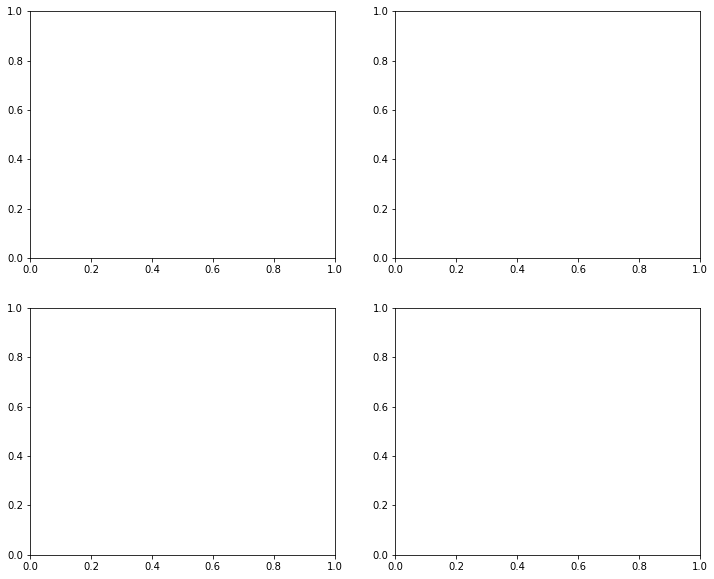

In [47]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

phams = sorted(list(df_genes["pham"].unique()))
unique_cluster = []
for i in phams:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Pham")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Pham", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Pham")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Pham", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per Pham")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Pham")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Pham", scipy.stats.describe(unique_cluster))


plt.show()

###### Genes/Clusters per Function

KeyError: '-1'

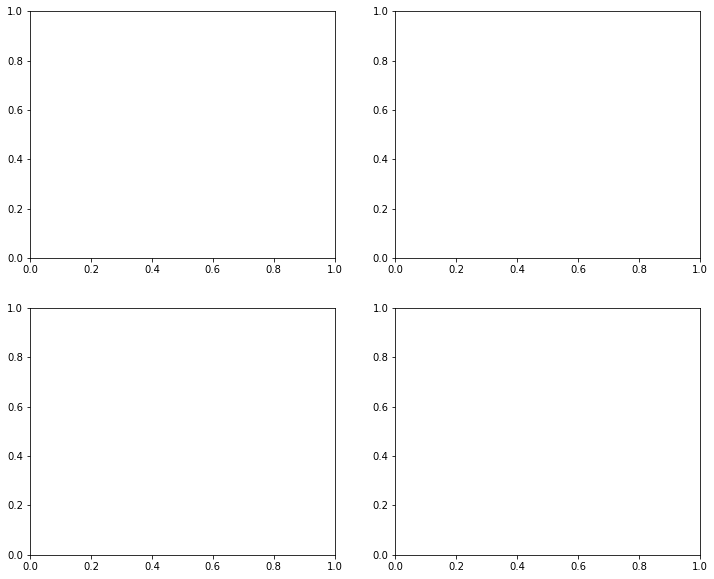

In [46]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

functions = sorted(list(df_genes["function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Function")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Function")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Function", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per function")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Function")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Function", scipy.stats.describe(unique_cluster))


plt.show()


In [ ]:
G.copy()


edge_cut_prop = np.linspace(0.01, 1.0, num=10)
true_ratio = []
false_ratio = []
true_count = []
false_count = []
total_count = []
for prop in edge_cut_prop:
    true = 0
    false = 0
    count = 0
    for i, j in G.edges():
        func = i if G.nodes[i]["group"] == "function" else j
        pham = i if G.nodes[i]["group"] == "pham" else j
        num_pham_members = G.nodes[pham]["freq"]
        if G.edges[i,j]["weight"]/num_pham_members < prop:
            if func.lower() in funcList:
                true += 1
            else:
                false += 1
            count += 1

    true_ratio += [true/count]
    false_ratio += [false/count]
    true_count += [true]
    false_count += [false]
    total_count += [count]

In [ ]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_ratio)

plt.fill_between(edge_cut_prop, false_ratio, [1]*len(edge_cut_prop),
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_ratio,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("proportion")
plt.xlabel("proportion threshold to cut an edge")
plt.legend()


plt.title("Edge Cutting")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_count)

plt.fill_between(edge_cut_prop, false_count, total_count,
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_count,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("count of cut edges")
plt.xlabel("proportion threshold to cut an edge (weight of edge(pham member of a func)/total number of pham members)")
plt.legend()

plt.title("Edge Cutting")
plt.show()

### Faulty Code in the VOID

In [17]:
cat = "Pham"
phams = sorted(list(df_genes[cat].unique()))
clusters = sorted(list(df_genes["Cluster"].unique()))

# empty array for results
a = [0]*df_genes["Cluster"].nunique()
pham_cluster = [a for _ in phams]

print(len(pham_cluster))
print(len(pham_cluster[0]))
#make a dict for clusters
for p in range(len(phams)):
    total = len(G.nodes[phams[p]]["clusters"])
    for c in range(len(clusters)):
        pham_cluster[p][c] = G.nodes[phams[p]]["clusters"].count(clusters[c])/total



23208
274


/Users/skymartin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


<AxesSubplot:>

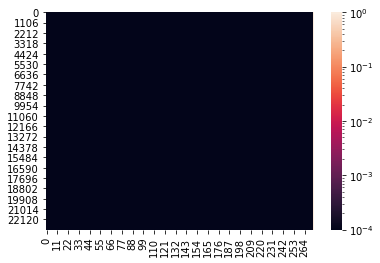

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sn
import matplotlib.colors as colors

import math
data =  np.array(pham_cluster) + 0.0001

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

sn.heatmap(
    data,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
)

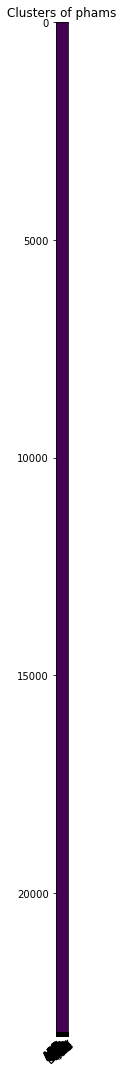

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(pham_cluster)

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
# ax.set_yticks(np.arange(len(pham)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
# ax.set_yticklabels(pham)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(pham)):
#     for j in range(len(clusters)):
#         text = ax.text(j, i, pham_cluster[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Clusters of phams")
fig.tight_layout()
plt.show()

In [20]:
# https://networkx.github.io/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html#networkx.convert.from_dict_of_dicts
# dod = {0: {1: {"weight": 1}}}  # single edge (0,1)
# G = nx.from_dict_of_dicts(dod)

In [21]:
# DICT OF DICT APPROACH, DIDN'T WORK AS DESIRED BECAUSE IT ASSUMES DIRECTION
# dod = {}
# i = 0
# for _, row in df.iterrows(): 
#     if row["Pham"] in dod.keys() and row["Function"] in dod[row["Pham"]].keys():
#         dod[row["Pham"]][row["Function"]]["weight"] += 1
#         if row["Cluster"] in dod[row["Pham"]][row["Function"]]["clusters"].keys():
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] += 1
#         else:
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] = 1
        
#     elif row["Pham"] in dod.keys():
#         dod[row["Pham"]][row["Function"]] = {"weight":1, "clusters": {row["Cluster"]:1}}
#     else:
#         dod[row["Pham"]] = {row["Function"]:{"weight":1, "clusters": {row["Cluster"]:1}}}
#     i += 1
#     if i>3:
#         break
# print(dod)
# G = nx.from_dict_of_dicts(dod)
# nx.draw_networkx(G, node_size=2)

In [22]:
# nx.write_gexf(G, "Bipartite_Gene_Graph.gexf")

In [23]:
# make a mapping for ability to add values in matrix {value: index,...}
# pham_mapping = {}
# for p in range(len(phams)):
#     pham_mapping[phams[p]] = p
    
# cluster_mapping = {}
# for c in range(len(clusters)):
#     cluster_mapping[clusters[c]] = c